In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [13]:
aqi_df = pd.read_csv('datasets/aqi.csv', index_col = 0)
aqi_df['DATE'] = pd.to_datetime(aqi_df['DATE'])
aqi_df.head()

,STATE_NAME,COUNTY_NAME,STATE_CODE,COUNTY_CODE,DATE,AQI,CATEGORY,DEFINING_PARAMETER,DEFINING_SITE,NUMBER_OF_SITES_REPORTING,YEAR
0,Alabama,Calhoun,1,15,1992-01-01,12,Good,PM10,01-015-0001,1,1992
1,Alabama,Calhoun,1,15,1992-01-07,28,Good,PM10,01-015-0001,1,1992
2,Alabama,Calhoun,1,15,1992-01-13,6,Good,PM10,01-015-0001,1,1992
3,Alabama,Calhoun,1,15,1992-01-19,12,Good,PM10,01-015-0001,1,1992
4,Alabama,Calhoun,1,15,1992-01-25,13,Good,PM10,01-015-0001,1,1992


In [12]:
fire_df = pd.read_csv('datasets/fires.csv', index_col = 0)
fire_df['DISCOVERY_DATE'] = pd.to_datetime(fire_df['DISCOVERY_DATE'])
fire_df['CONT_DATE'] = pd.to_datetime(fire_df['CONT_DATE'])
fire_df.head()

,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,...,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,COUNTY,COUNTY_CODE,FIPS_NAME,STATE_NAME,COUNTY_NAME,STATE_CODE
0,,,,,,,,,,,,,,,,,,,,,
0,BEV0,TONSINA CREEK,2005,2005-04-28,118,1250.0,Campfire,2005-04-29,119.0,2100.0,...,60.053333,-149.440000,13.0,STATE OR PRIVATE,122.0,122,Kenai Peninsula,Alaska,Kenai Peninsula,2
1,BEV0,PETERSON CREEK,2005,2005-05-08,128,1715.0,Miscellaneous,2005-05-10,130.0,1800.0,...,60.885000,-149.045000,5.0,USFS,122.0,122,Kenai Peninsula,Alaska,Kenai Peninsula,2
2,BEV0,TWENTY MILE,2005,2005-05-09,129,930.0,Debris Burning,2005-05-09,129.0,1030.0,...,60.861667,-148.995000,13.0,STATE OR PRIVATE,122.0,122,Kenai Peninsula,Alaska,Kenai Peninsula,2
3,C63B,MOTORHOME,2007,2007-06-01,152,1415.0,Miscellaneous,2007-06-01,152.0,1640.0,...,60.450278,-149.366944,13.0,STATE OR PRIVATE,122.0,122,Kenai Peninsula,Alaska,Kenai Peninsula,2
4,C63B,POWER,2007,2007-06-09,160,1430.0,Campfire,2007-06-09,160.0,1450.0,...,60.466944,-149.700278,5.0,USFS,122.0,122,Kenai Peninsula,Alaska,Kenai Peninsula,2


In [32]:
# add month and year to each
fire_df['MONTH'] = fire_df['DISCOVERY_DATE'].dt.month
fire_df['YEAR'] = fire_df['DISCOVERY_DATE'].dt.year
aqi_df['MONTH'] = aqi_df['DATE'].dt.month
aqi_df['YEAR'] = aqi_df['DATE'].dt.year

In [80]:
# for every state, get total acres burned and average aqi each month for every year (all by discovery date)
mode_scalar = lambda x: pd.Series.mode(x)[0]
fire_size_biggest = lambda x: pd.Series.mode(x)[0]

aqi_g = aqi_df.groupby(by=["MONTH", "YEAR", "STATE_NAME"]).agg({'AQI': ['mean', 'max'],\
                                                                'CATEGORY': [mode_scalar]})
fire_g = fire_df.groupby(by=["MONTH", "YEAR", "STATE_NAME"]).agg({'FIRE_SIZE': ['sum', 'max', 'count'],\
                                                                'COUNTY_CODE': [mode_scalar],\
                                                                'FIPS_NAME': [mode_scalar],\
                                                                'STAT_CAUSE_DESCR': [mode_scalar]})

In [81]:
# rename columns and make column not a multi-index
lam_to_mode = lambda x: 'MODE' if x == '<lambda>' else x.upper()
fire_g.columns = [f"{col[0]}_{lam_to_mode(col[1])}" for col in fire_g.columns.values]
aqi_g.columns = [f"{col[0]}_{lam_to_mode(col[1])}" for col in aqi_g.columns.values]

In [155]:
# do the final join
final_df = fire_g.join(aqi_g, how='outer')
to_fill = ['FIRE_SIZE_SUM', 'FIRE_SIZE_MAX', 'FIRE_SIZE_COUNT', 'AQI_MEAN', 'AQI_MAX']
final_df[to_fill] = final_df[to_fill].fillna(0)
final_df = final_df.reset_index()
final_df = final_df.sort_values(by=['STATE_NAME', 'YEAR', 'MONTH'])
# states to drop
states_drop = ['District Of Columbia', 'Country Of Mexico', 'Virgin Islands', 'Puerto Rico']
final_df = final_df[[(state not in states_drop) for state in final_df['STATE_NAME']]]
final_df.head()

,MONTH,YEAR,STATE_NAME,FIRE_SIZE_SUM,FIRE_SIZE_MAX,FIRE_SIZE_COUNT,COUNTY_CODE_MODE,FIPS_NAME_MODE,STAT_CAUSE_DESCR_MODE,AQI_MEAN,AQI_MAX,CATEGORY_MODE
0,1,1992,Alabama,0.0,0.0,0.0,NaN,NaN,NaN,29.023411,178,Good
1295,2,1992,Alabama,0.0,0.0,0.0,NaN,NaN,NaN,34.312000,200,Good
2591,3,1992,Alabama,0.0,0.0,0.0,NaN,NaN,NaN,36.075061,146,Good
3887,4,1992,Alabama,0.0,0.0,0.0,NaN,NaN,NaN,42.039370,136,Good
5183,5,1992,Alabama,0.0,0.0,0.0,NaN,NaN,NaN,52.549751,200,Good


In [ ]:
# important cols for plotting
states = list(set(final_df['STATE_NAME']))
states = sorted(states)
months = list(set(final_df['MONTH']))
years = list(set(final_df['YEAR']))

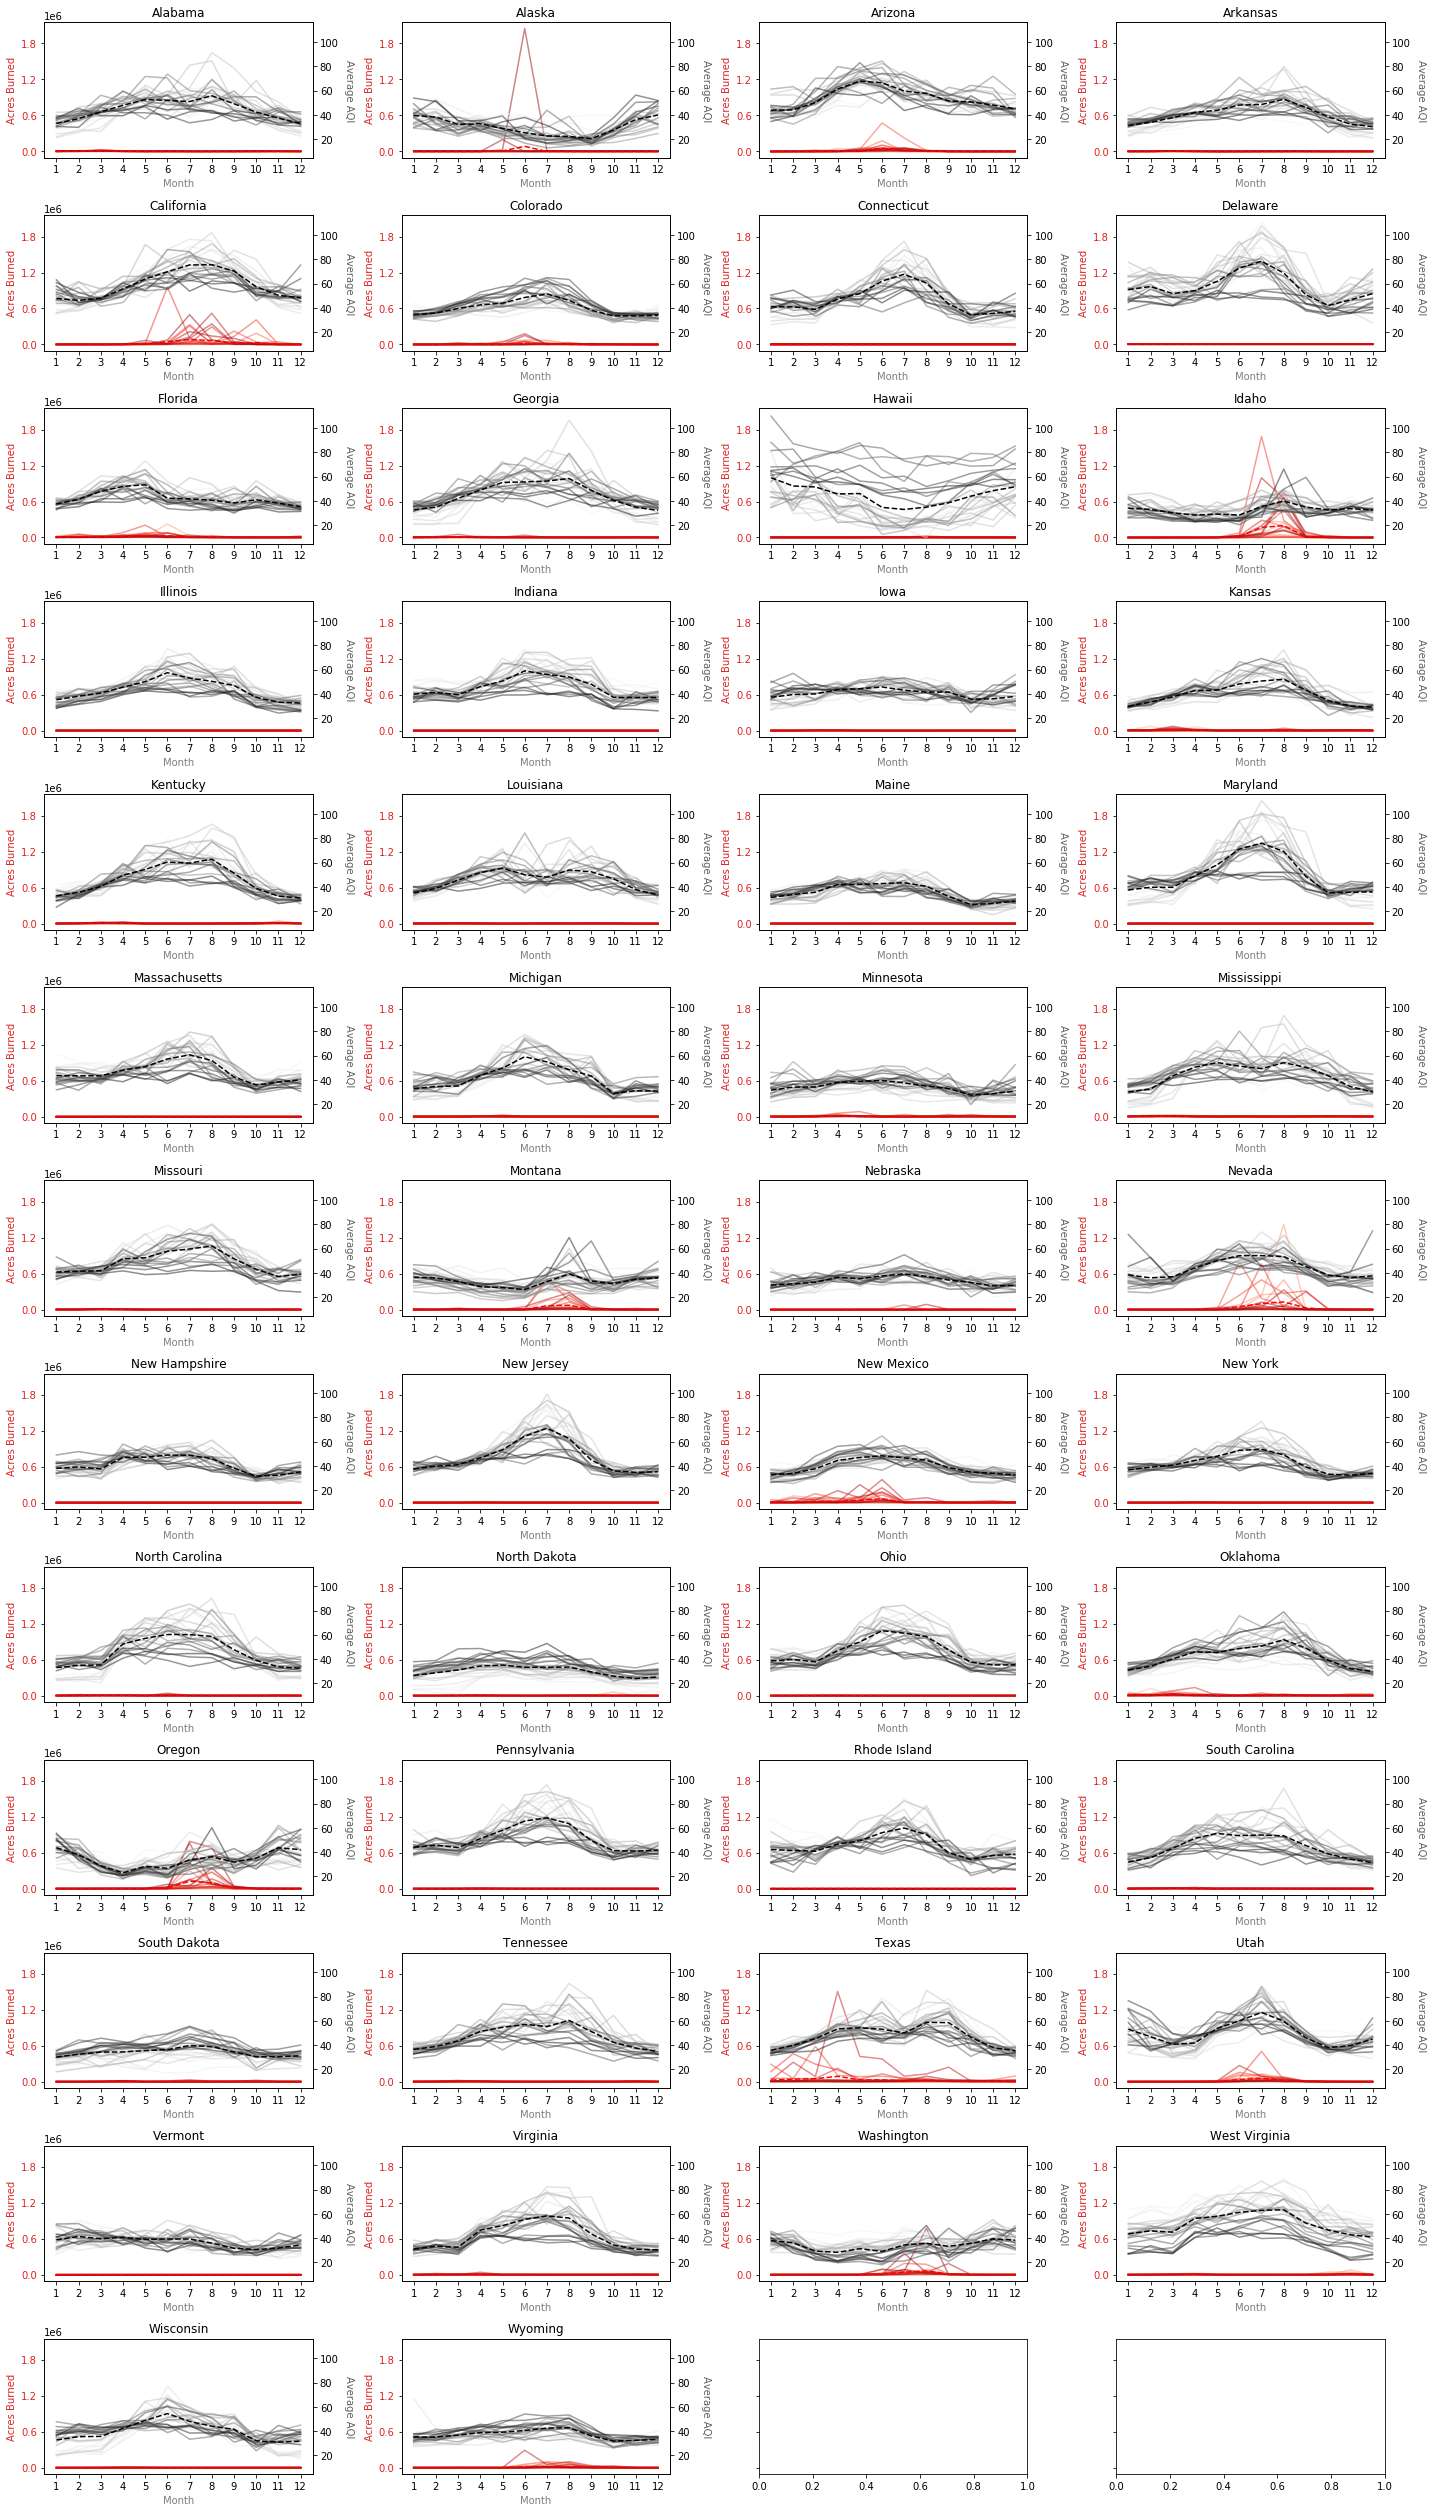

In [253]:
# now do plotting!
sharey=True

# gradient of greys for years
grey_colors = [plt.get_cmap('Greys')(x) for x in np.linspace(.1, .9, len(years))]
red_colors = [plt.get_cmap('Reds')(x) for x in np.linspace(.1, .9, len(years))]

# make subplots
c = 4
r = int(len(states)/c)
r = r + 1 if len(states)%c != 0 else r
fig, axs = plt.subplots(nrows=r,ncols=c, sharey=sharey)
axs = axs.flatten()
axts = [axs[i].twinx() for i in range(len(states))]
# join twin axis
if sharey:
    for i in range(len(states)-1):
        axts[i].get_shared_y_axes().join(axts[i], axts[i+1])
fig.set_size_inches(20,35)
# go and add each state
for i, state in enumerate(states):
    # also save to its own file for each state
    figS, axS = plt.subplots()
    axS = axS
    figS.set_size_inches(5,4)
    axtS = axS.twinx()
    axS.yaxis.set_tick_params(labelleft=True)
    axS.yaxis.set_major_locator(plt.MaxNLocator(4))
    axS.set_xticks(months)
    
    # format both axes
    ax = axs[i]
    axt = axts[i]
    ax.yaxis.set_tick_params(labelleft=True)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.set_xticks(months)
    
    # get data
    state_df = final_df[final_df['STATE_NAME'] == state].groupby('YEAR')
    for grey, red, (year, year_df) in zip(grey_colors, red_colors, state_df):
        # plot the fire sizes each month
        ax.plot(year_df['MONTH'], year_df['FIRE_SIZE_SUM'], color=red, alpha = .5)
        # plot the avg aqi each month
        axt.plot(year_df['MONTH'], year_df['AQI_MEAN'], color=grey, alpha = .5)
        
        # also plot on state file
        axS.plot(year_df['MONTH'], year_df['FIRE_SIZE_SUM'], color=red, alpha = .5)
        axtS.plot(year_df['MONTH'], year_df['AQI_MEAN'], color=grey, alpha = .5)
        figS.show()
        
    # add average of each metric
    state_agg = final_df[final_df['STATE_NAME'] == state].groupby('MONTH')\
                    .agg({'AQI_MEAN': ['mean'], 'FIRE_SIZE_SUM': ['mean']})
    state_agg.columns = [f"{col[0]}_{lam_to_mode(col[1])}" for col in state_agg.columns.values]
    ax.plot(state_agg.index, state_agg['FIRE_SIZE_SUM_MEAN'], color='red', linestyle='dashed')
    axt.plot(state_agg.index, state_agg['AQI_MEAN_MEAN'], color='black', linestyle='dashed')
    # also plot on state file
    axS.plot(state_agg.index, state_agg['FIRE_SIZE_SUM_MEAN'], color='red', linestyle='dashed')
    axtS.plot(state_agg.index, state_agg['AQI_MEAN_MEAN'], color='black', linestyle='dashed')
    
    # add axis labels
    ax.set_title(state)  
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_xlabel('Month', color='tab:grey')
    ax.set_ylabel('Acres Burned', color=plt.get_cmap('Reds')(0.7))
    axt.set_ylabel('Average AQI', color=plt.get_cmap('Greys')(0.7), rotation=270, labelpad=15)
    for t in ax.get_yticklabels():
        t.set_visible(True)
        t.set_color(plt.get_cmap('Reds')(0.7))
    
    # state level plot saving and labeling
    axS.set_title(state)  
    axS.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    axS.set_xlabel('Month', color='tab:grey')
    axS.set_ylabel('Acres Burned', color=plt.get_cmap('Reds')(0.7))
    axtS.set_ylabel('Average AQI', color=plt.get_cmap('Greys')(0.7), rotation=270, labelpad=15)
    for t in axS.get_yticklabels():
        t.set_visible(True)
        t.set_color(plt.get_cmap('Reds')(0.7))
    figS.tight_layout()
    figS.savefig(f'analysis_plots/state_level_monthly_paired_view/monthly_paired_view_{state}.svg')
    plt.close(figS)
# minimum dist between subplots
fig.subplots_adjust(wspace=.5, hspace=.7)
fig.tight_layout()
fig.savefig(f'analysis_plots/monthly_paired_view_sharey_{sharey}.svg')
plt.show()
plt.close()

In [254]:
# make a legend plot for the above plots
fig, ax = plt.subplots()
fig.set_size_inches(16,5)
fig.patch.set_visible(False)
ax.axis('off')
for grey, red, (year, year_df) in zip(grey_colors, red_colors, state_df):
    # plot the fire sizes each month
    plt.plot([], [], color=red, alpha = .5, linewidth=10, label = f"Acres Burned {year}")
    # plot the avg aqi each month
    plt.plot([], [], color=grey, alpha = .5, linewidth=10, label = f"Avg AQI {year}")
ax.plot([],[], color='red', linestyle='dashed', linewidth=4, label='Avg Acres Burned')
ax.plot([],[], color='black', linestyle='dashed', linewidth=4, label='Avg AQI')
ax.legend(fontsize='large', ncol=5,handleheight=2.4, labelspacing=0.05)
plt.tight_layout()
plt.savefig('analysis_plots/legend_monthly_paired_view.svg')
plt.close()

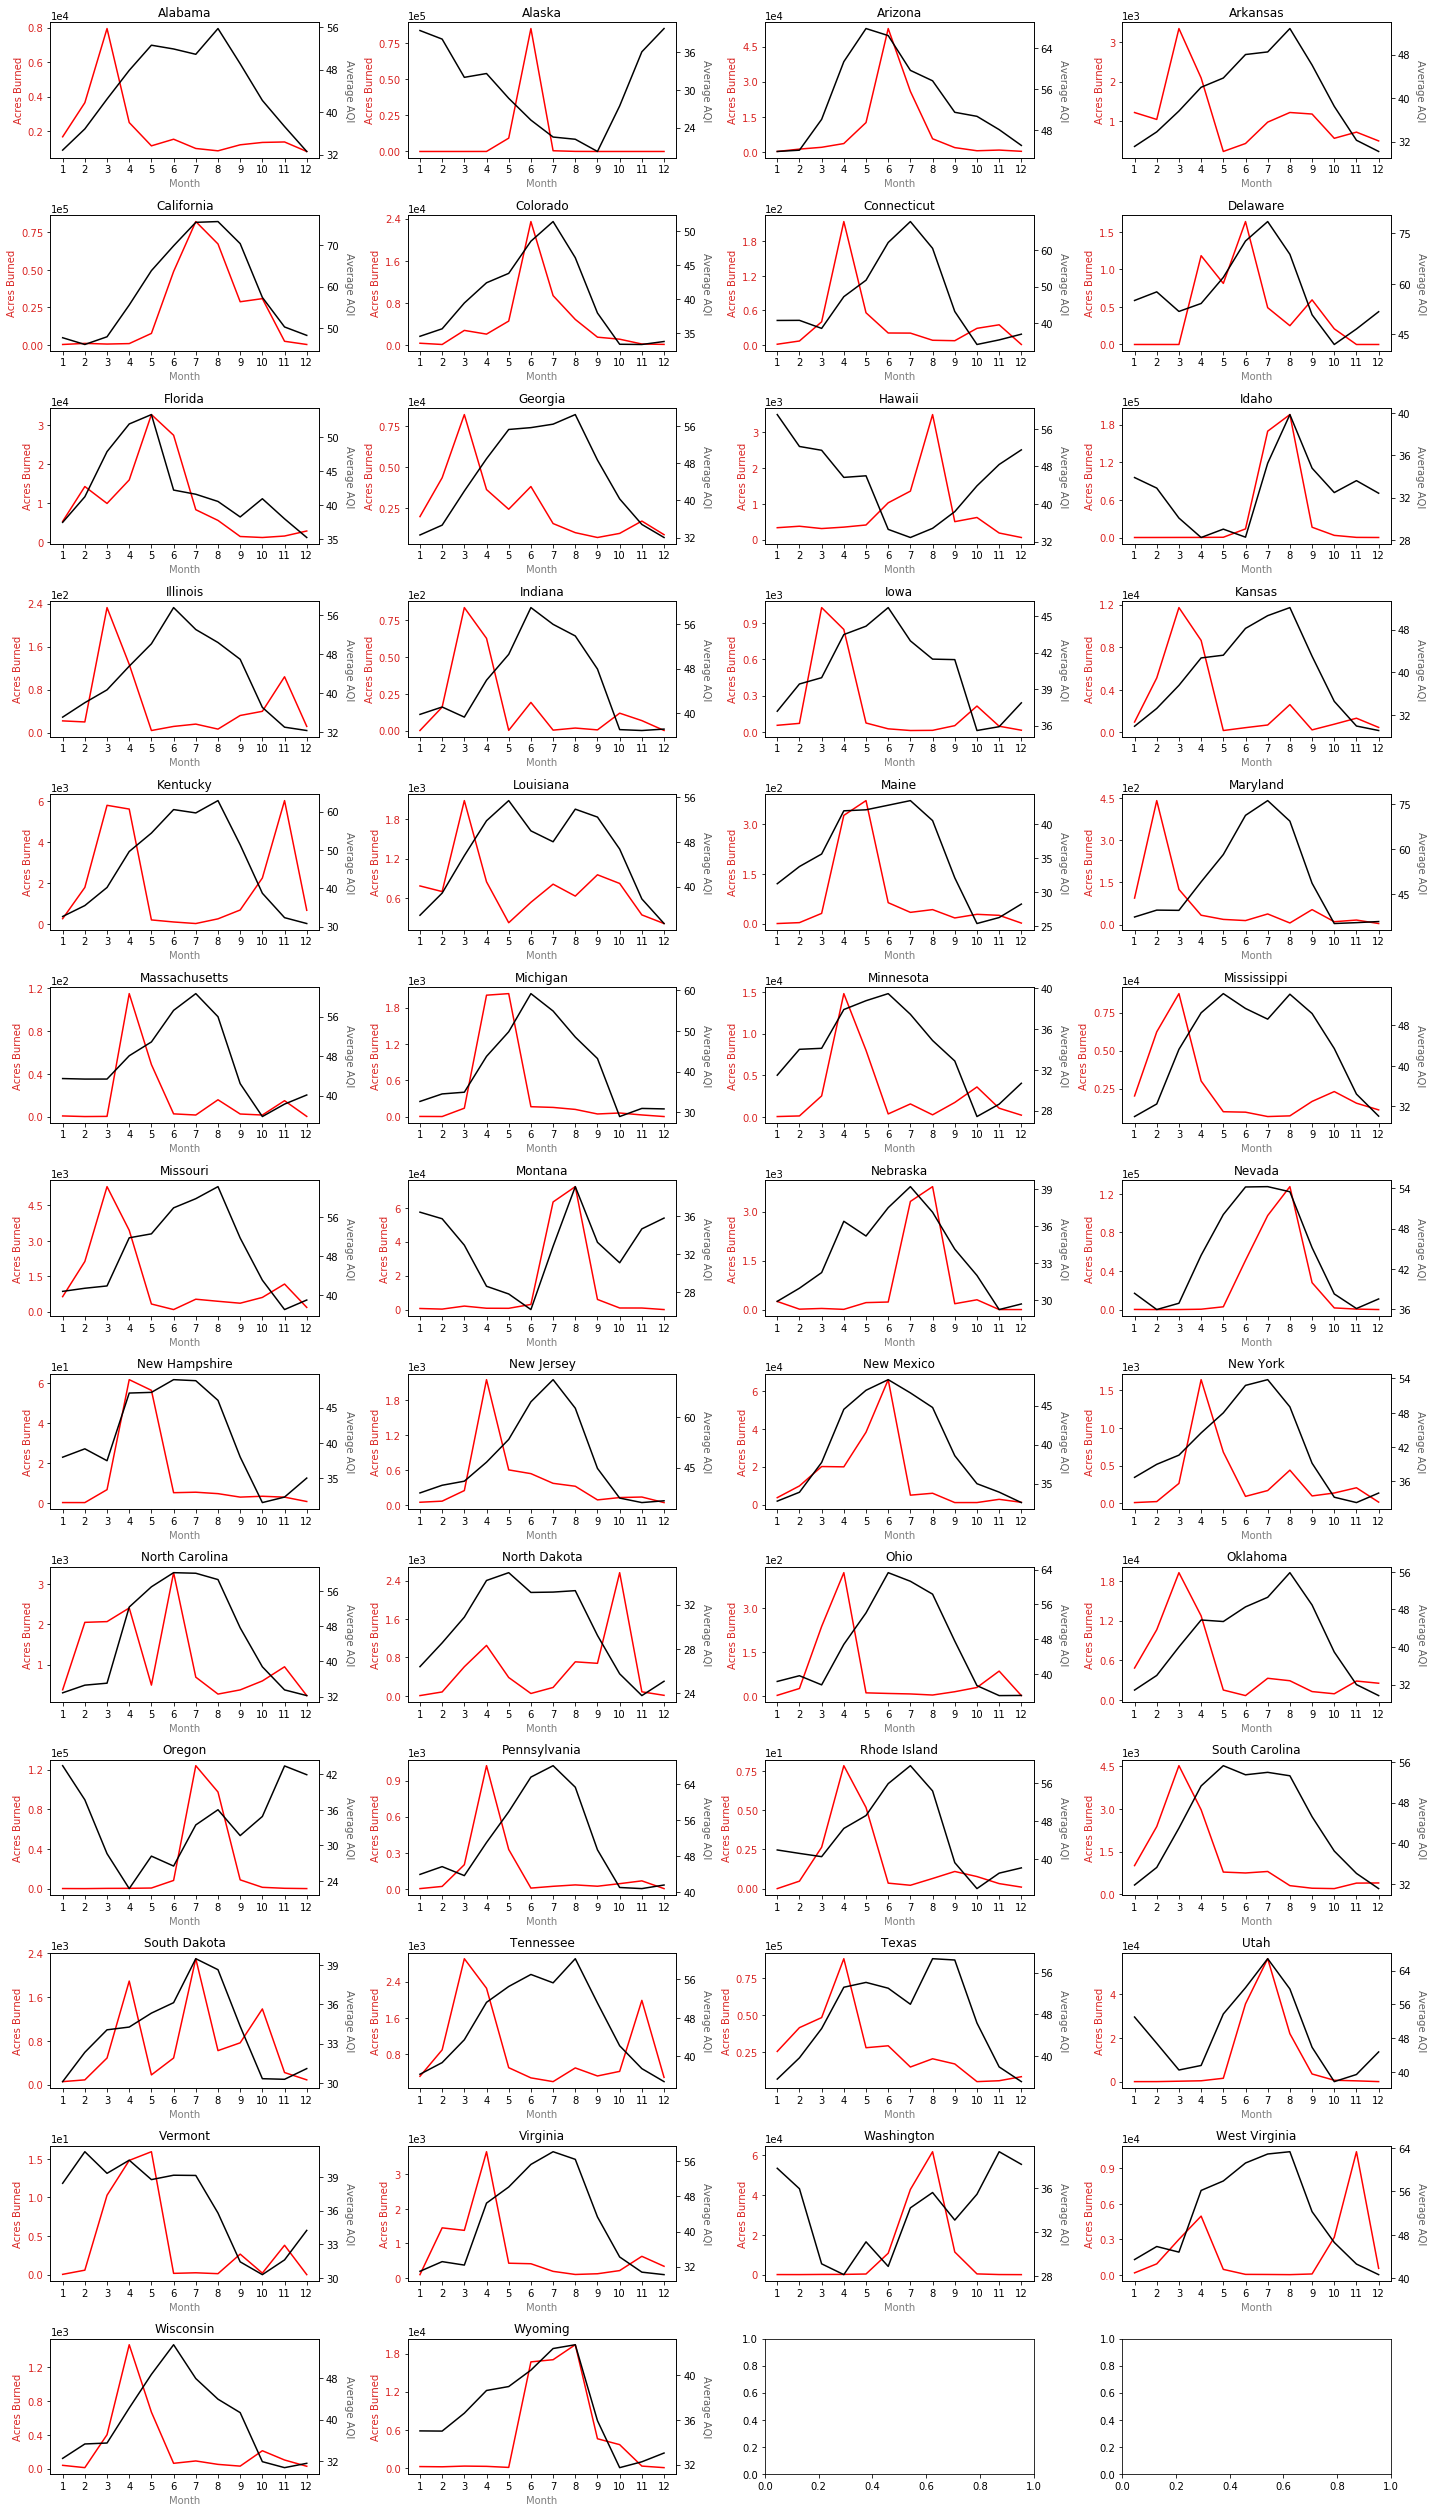

In [251]:
# now do just the average
sharey = False

# make subplots
c = 4
r = int(len(states)/c)
r = r + 1 if len(states)%c != 0 else r
fig, axs = plt.subplots(nrows=r,ncols=c, sharey=sharey)
axs = axs.flatten()
axts = [axs[i].twinx() for i in range(len(states))]
# join twin axis
if sharey:
    for i in range(len(states)-1):
        axts[i].get_shared_y_axes().join(axts[i], axts[i+1])

fig.set_size_inches(20,35)
# go and add each state
for i, state in enumerate(states):
    # also save to its own file for each state
    figS, axS = plt.subplots()
    axS = axS
    figS.set_size_inches(5,4)
    axtS = axS.twinx()
    axS.yaxis.set_tick_params(labelleft=True)
    axS.yaxis.set_major_locator(plt.MaxNLocator(4))
    axS.set_xticks(months)
    
    # format both axes
    ax = axs[i]
    axt = axts[i]
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.set_xticks(months)
    axt.yaxis.set_major_locator(plt.MaxNLocator(4))
        
    # add average of each metric
    state_agg = final_df[final_df['STATE_NAME'] == state].groupby('MONTH')\
                    .agg({'AQI_MEAN': ['mean'], 'FIRE_SIZE_SUM': ['mean']})
    state_agg.columns = [f"{col[0]}_{lam_to_mode(col[1])}" for col in state_agg.columns.values]
    ax.plot(state_agg.index, state_agg['FIRE_SIZE_SUM_MEAN'], color='red')
    axt.plot(state_agg.index, state_agg['AQI_MEAN_MEAN'], color='black')
    # also plot on state file
    axS.plot(state_agg.index, state_agg['FIRE_SIZE_SUM_MEAN'], color='red')
    axtS.plot(state_agg.index, state_agg['AQI_MEAN_MEAN'], color='black')
    
    # add axis labels
    ax.set_title(state)
    ax.yaxis.set_tick_params(labelleft=True)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_xlabel('Month', color='tab:grey')
    ax.set_ylabel('Acres Burned', color=plt.get_cmap('Reds')(0.7))
    axt.set_ylabel('Average AQI', color=plt.get_cmap('Greys')(0.7), rotation=270, labelpad=15)
    for t in ax.get_yticklabels():
        t.set_visible(True)
        t.set_color(plt.get_cmap('Reds')(0.7))
    
    # state level plot saving and labeling
    axS.set_title(state)  
    axS.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    axS.set_xlabel('Month', color='tab:grey')
    axS.set_ylabel('Acres Burned', color=plt.get_cmap('Reds')(0.7))
    axtS.set_ylabel('Average AQI', color=plt.get_cmap('Greys')(0.7), rotation=270, labelpad=15)
    for t in axS.get_yticklabels():
        t.set_visible(True)
        t.set_color(plt.get_cmap('Reds')(0.7))
    figS.tight_layout()
    figS.savefig(f'analysis_plots/state_level_monthly_paired_view/monthly_paired_view_avg_{state}.svg')
    plt.close(figS)
# minimum dist between subplots
fig.subplots_adjust(wspace=.5, hspace=.7)
fig.tight_layout()
plt.savefig(f'analysis_plots/monthly_paired_view_avg_yshare_{sharey}.svg')
plt.show()
plt.close()